To add:
- categorical
- cost function selection
- random forests
- boosting

Learned:
- lot of recursion practice
- practice with tree data structions, searching/editing
- much cleaner implementation, much more thought before coding, less rewriting
- OOP so necessary, data storage/access unrivaled, class/subclasses as well
- enjoy recursion much more than traditional, concise but trickier

In [13]:
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

gini-impurity loss function

In [14]:
def gini_impurity(X,Y):
    X, Y = X.to_numpy(), Y.to_numpy()
    classes = np.unique(Y)
    gini_sum = 0
    for cls in classes:
        X_cls = X[Y == cls]
        p = len(X_cls)/len(X) #finds proportion of class / total data
        gini_sum += p**2
    return 1 - gini_sum #return impurity value

get thresholds, midpoints between data

In [15]:
def get_poss_thresholds(df):
    df = df.to_numpy()
    X = np.sort(np.unique(df)) #array of unique values in ascending order
    poss_thresholds = []
    for i in range(len(X)-1):
        left = X[i]
        right = X[i+1]
        midpoint = (left+right)/2 #find midpoints
        poss_thresholds += [midpoint]
    return poss_thresholds

get value, finds highest percentage of class

In [16]:
def get_value(X, Y):
    X, Y = X.to_numpy(), Y.to_numpy()
    classes = np.unique(Y)
    highest_prop = 0
    highest_class = None
    for cls in classes:
        X_cls = X[Y == cls]
        p = len(X_cls)/len(X)
        if p > highest_prop:
            highest_prop = p
            highest_class = cls
    return highest_class

get misclass, finds pmax

In [17]:
def get_misclass(X,Y):
    X, Y = X.to_numpy(), Y.to_numpy()
    classes = np.unique(Y)
    highest_prop = 0
    for cls in classes:
        X_cls = X[Y == cls]
        p = len(X_cls)/len(X)
        if p > highest_prop:
            highest_prop = p
    return 1- highest_prop

given data set, finds optimal split

In [18]:
def find_best_split(X, Y):
            best_gini = float("inf")
            best_threshold = None
            features = X.columns

            #iterates through features, gets mid point thresholds
            for i in range(len(features)):
                ft = features[i]
                poss_thresholds = get_poss_thresholds(X[ft])

                for thresh in poss_thresholds:
                    #splits data by threshold, saves lowest impurity
                    left_X, left_Y = X[X[ft] < thresh], Y[X[ft] < thresh]
                    right_X, right_Y = X[X[ft] >= thresh], Y[X[ft] >= thresh]
                    
                    gini_left = gini_impurity(left_X, left_Y)
                    w_left = len(left_X) / len(X)
                    gini_right = gini_impurity(right_X, right_Y)
                    w_right = len(right_X) / len(X)

                    gini_sum = w_left*gini_left + w_right*gini_right

                    if gini_sum < best_gini:
                        best_gini = gini_sum
                        best_threshold = thresh
            
            #returns feature index and threshold
            return i, best_threshold

classify, given single input vector, returns class

In [19]:
def classify(datum, curr_node):
    if curr_node.value is not None:
        return curr_node.value
    else:
        feature = curr_node.feature
        if datum[feature] < curr_node.threshold:
            return classify(datum, curr_node.left)
        else:
            return classify(datum, curr_node.right)

tree and node class

In [20]:
class tree:
    def __init__(self):
        self.max_depth = None
        self.min_sample_leaves = None
        self.root = None
    
    def fit(self, X, Y, max_depth = float('inf'), min_sample_leaves = 0, 
            alpha = .01):
        #sets pre-pruning and post-pruning parameters
        self.classes = X.columns
        self.max_depth = max_depth
        self.min_sample_leaves = min_sample_leaves
        self.root = self.node(depth = 1, parent = None, tree = self)
        self.root.grow_tree(X,Y)

        self.alpha = alpha
        self.root.prune(alpha)

    #classifies predicted data, returns data frame
    def predict(self, X):
        root = self.root
        X = X.to_numpy()
        Y_pred = []
        for datum in X:
            Y_pred.append(classify(datum, root))
        return pd.DataFrame(Y_pred, columns=['output'])

    def visualize(self):
        self.root.visualize(self.classes)

    class node:
        def __init__(self, feature=None, threshold=None, gini_loss=None,
                     left=None, right=None, value=None, depth=None, parent=None,
                     tree=None, misclass=None):
            self.feature = feature  # feature index to split on
            self.threshold = threshold  # Threshold value for the split
            self.gini_loss = gini_loss # Current Gini-impurity at that node
            self.left = left  # Left subtree
            self.right = right  # Right subtree
            self.value = value  # Value for leaf nodes (class label)
            self.depth = depth # Depth of node in tree
            self.parent = parent # Parent node
            self.tree = tree # Only for roots, connects back to tree
            self.misclass = misclass # Misclassification at node
        
        #runs back up tree to get root.tree
        def get_tree(self):
            current_node = self
            while current_node.parent is not None:
                current_node = current_node.parent
            return current_node.tree
        
        #creates left, right nodes based on split
        def grow_tree(self, X, Y):
            #set error metrics
            self.gini_loss = gini_impurity(X,Y)
            self.misclass = get_misclass(X,Y)

            #checking to see if hit max depth or min number of data entries
            tree = self.get_tree()
            max_depth = tree.max_depth
            min_sample_leaves = tree.min_sample_leaves
            
            #if node is pure, no more data to split, or pre-pruning stop recursion, set value
            #base case
            if (self.depth > max_depth or len(X) <= min_sample_leaves
                or self.gini_loss == 0 or len(X) <= 1):
                self.value = get_value(X,Y)
                return

            #set threshold and feature
            self.feature, self.threshold = find_best_split(X,Y)

            #split data
            ft = X.columns[self.feature]
            thresh = self.threshold

            left_X, left_Y = X[X[ft] < thresh], Y[X[ft] < thresh]
            right_X, right_Y = X[X[ft] >= thresh], Y[X[ft] >= thresh]

            #check if all data end up on one side, can't split effectively
            #then grow tree, recursively call
            if len(left_X) > 0  and len(right_X) > 0:
                self.left = tree.node(depth = self.depth + 1, parent = self, )
                self.left.grow_tree(left_X, left_Y)
        
                self.right = tree.node(depth = self.depth + 1, parent = self)
                self.right.grow_tree(right_X, right_Y)
            else:
                self.value = get_value(X,Y)
                return
        
        def prune(self,alpha):
            #base case, if leaf node
            if self.value is not None:
                return
            else:
                #compares subtree cost and root cost
                sub_tree_remove = self.eval_sub_tree(alpha)
                if sub_tree_remove:
                    #stores leaf values in dict, root becomes new that majority value
                    #reset other attributes
                    value_dict = self.get_values({})
                    self.value = max(value_dict, key=value_dict.get)
                    self.left, self.right, self.feature, self.threshold = None, None, None, None
                    return
                else:
                    #descend true
                    left, right = self.left, self.right
                    left.prune(alpha)
                    right.prune(alpha)
        
        def sub_tree_cost(self):
            #base case, returns count of leaf and misclass
            if self.value is not None:
                error = self.misclass
                node_count = 1
                return error, node_count
            else:
                #sums misclass and node count across subtree
                left, right = self.left, self.right
                left_error, left_count = left.sub_tree_cost()
                right_error, right_count = right.sub_tree_cost()
   
                return (left_error+right_error), (left_count+right_count)

        def eval_sub_tree(self, alpha):
            root_cost = self.misclass

            sub_tree_error, sub_tree_count = self.sub_tree_cost()
            #sub tree cost = average misclass + alpha * node count
            sub_tree_cost = (sub_tree_error / sub_tree_count) + alpha * sub_tree_count

            if root_cost < sub_tree_cost:
                return True
            else:
                return False
        
        #collects sub tree leaf values
        def get_values(self,value_dict):
            if self.value is not None:
                if self.value in value_dict:
                    value_dict[self.value] += 1
                    return
                else:
                    value_dict[self.value] = 1
                    return
            else:
                left, right = self.left, self.right
                left.get_values(value_dict)
                right.get_values(value_dict)
            return value_dict
        
        #descends tree, prints info about nodes
        def visualize(self, classes):
            if self.value is not None:
                print(f"value = {self.value}")
                print(f"depth = {self.depth}")
                return
            else:
                print(f"thresh = {self.threshold}")
                print(f"feature = {classes[self.feature]}")
                print(f"depth = {self.depth}")
                #print(f"gini = {self.gini_loss}")
                self.left.visualize(classes)
                self.right.visualize(classes)
                      

testing

In [21]:
my_DT = tree()

df = pd.read_csv("heart.csv")
X = df[['trtbps','chol']]
Y = df["output"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
my_DT.fit(X_train, Y_train, max_depth = 3)

Y_pred = my_DT.predict(X_test)
accuracy = accuracy_score(Y_pred, Y_test)
print(accuracy)

my_DT.visualize()

0.6065573770491803
thresh = 245.5
feature = chol
depth = 1
thresh = 139.0
feature = chol
depth = 2
value = 0
depth = 3
value = 1
depth = 3
value = 0
depth = 2


sklearn

Accuracy: 0.62


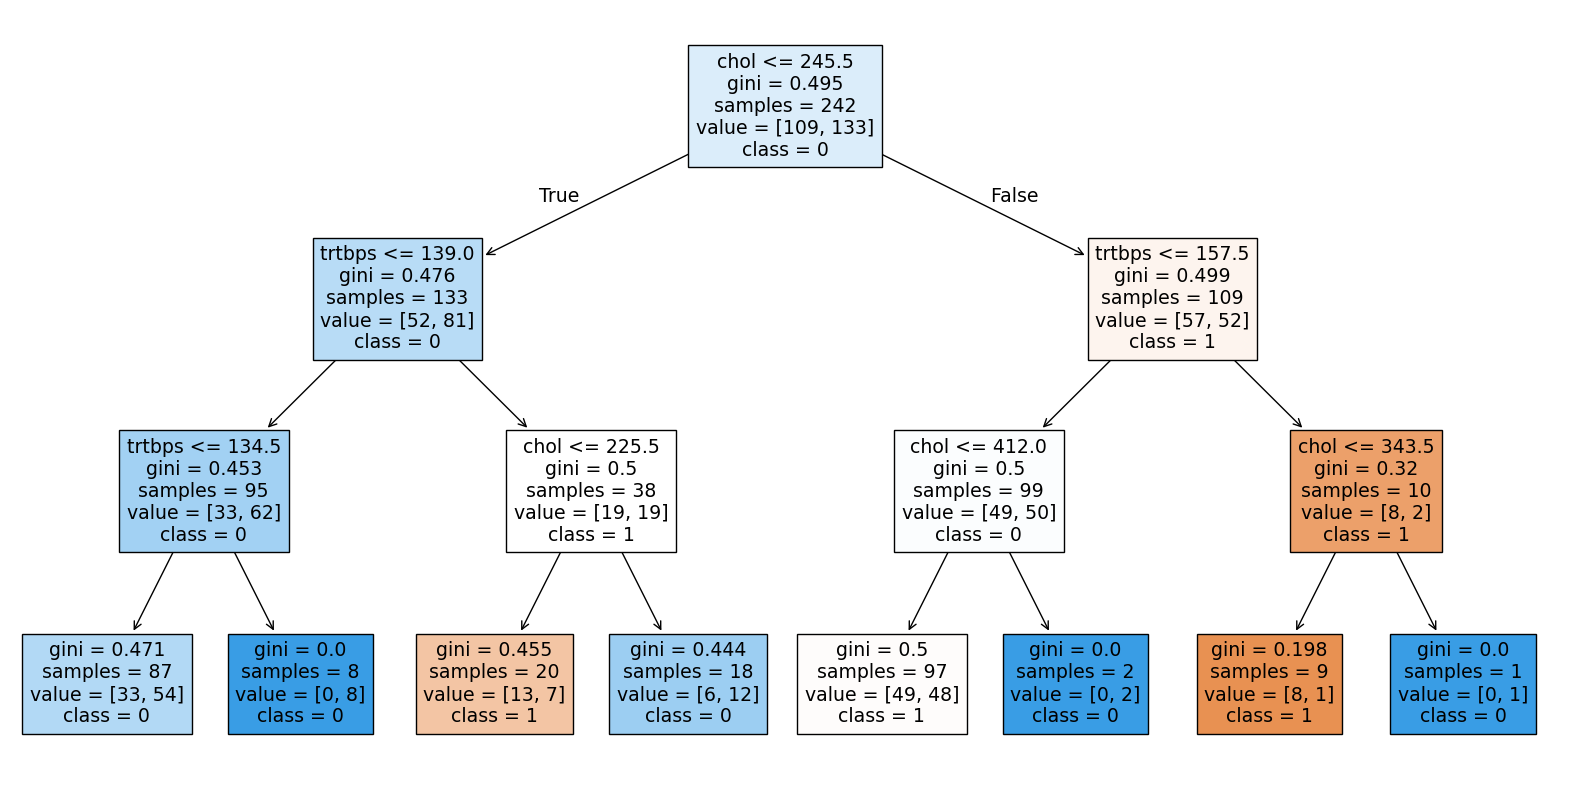

In [22]:
# Create and fit the model
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, Y_train)

feature_names = X.columns.tolist()
class_names = Y.unique().astype(str).tolist()

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()